In [4]:
from scipy.stats import poisson, lognorm, norm, cauchy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from time import monotonic

## Parameter estimation

In [5]:
def show_pdf(dist):
    minx, maxx = dist.ppf(0.0001), dist.ppf(0.9999)
    x = np.linspace(minx, maxx)
    plt.plot(x, dist.pdf(x))

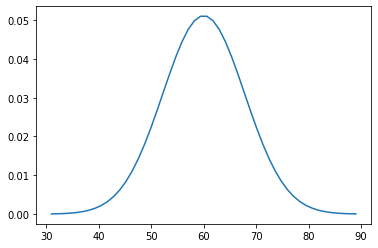

In [6]:
def norm_from_quartiles(x1, p1, x2, p2):
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)

    mean = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    scale = (x2 - x1) / (p2ppf - p1ppf)

    return norm(loc=mean, scale=scale)

def norm_range(x1, x2):
    return norm_from_quartiles(x1, 0.05, x2, 0.95)

dist = norm_from_quartiles(50, 0.10, 70, 0.90)
show_pdf(dist)

In [7]:
def lognorm_from_quartiles(x1, p1, x2, p2):
    x1 = np.log(x1)
    x2 = np.log(x2)
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)
    
    scale = (x2 - x1) / (p2ppf - p1ppf)
    mean = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    
    return lognorm(scale, scale=np.exp(mean))

def lognorm_range(x1, x2):
    return lognorm_from_quartiles(x1, 0.05, x2, 0.95)

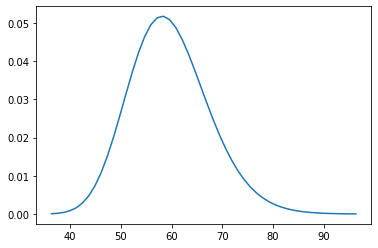

In [8]:
dist = lognorm_from_quartiles(50, 0.10, 70, 0.90)
show_pdf(dist)

In [9]:
def run_model(model, *params, N=1000):
    params = [x.rvs(N) if hasattr(x, 'rvs') else x for x in params]
    return model(*params)

## Model definition

-3064.881865199344

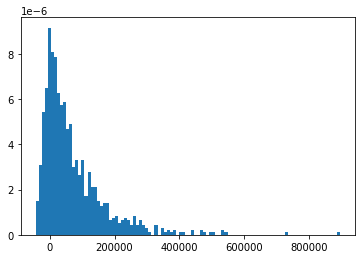

In [10]:
# Customer behaviour (not known)

customers_per_day = poisson(20)
spend_per_customer = lognorm_range(10, 90)
vat_mix = lognorm_range(7, 19)

# Labor costs (all known)

number_of_staff = 2
hourly_wage = 12
working_hours_per_day = 8
insurance_multiplier = 1.19325
labor_cost_per_day = (number_of_staff * hourly_wage * working_hours_per_day) * insurance_multiplier

# Business operations (all known)

income_tax = 1.42
cost_of_goods_percent = 0.3
working_days_per_year = 360

# The model (https://www.getguesstimate.com/models/3206)

def model(customers_per_day, spend_per_customer, vat_mix):
    net_expenditures_for_goods = spend_per_customer * cost_of_goods_percent
    revenue = customers_per_day * (spend_per_customer - net_expenditures_for_goods)

    earnings_before_taxes = revenue - labor_cost_per_day
    
    income_before_taxes = earnings_before_taxes * (1.0 / (1.0 + vat_mix/100))
    income_after_income_tax = income_before_taxes / income_tax
    
    income_per_year = income_after_income_tax * working_days_per_year
    
    return income_per_year
    

results = run_model(model, customers_per_day, spend_per_customer, vat_mix)

plt.hist(results, bins=100, density=True);

np.mean(results.clip(max=0))

## What if we know stuff?

In [46]:
N = 10000
S = 100

reality = pd.DataFrame({
    'customers_per_day': customers_per_day.rvs(N),
    'spend_per_customer': spend_per_customer.rvs(N),
    'vat_mix': vat_mix.rvs(N)
})

reality.head()

,customers_per_day,spend_per_customer,vat_mix
0,24,33.607823,16.960007
1,12,42.524393,8.593869
2,16,15.310855,22.275832
3,22,50.676589,6.803262
4,24,99.316990,11.954218


In [62]:
t = monotonic()

results = defaultdict(list)
# The naive decision will always be the same. Simulate the model with our existing uncertainty,
# and decide to open the flower shop if the expected value is greater than zero.

naive = run_model(model, customers_per_day, spend_per_customer, vat_mix).mean() > 0

customers_simulation = customers_per_day.rvs(S)
spend_simulation = spend_per_customer.rvs(S)
mix_simulation = vat_mix.rvs(S)

for _, example in reality.iterrows():    
    real_result = run_model(model, *example)
    
    # Knows about customers per day
    known_customers = run_model(model, example.customers_per_day, spend_simulation, mix_simulation).mean() > 0
    
    # Knows about spend per customer
    known_spend_per_customer = run_model(model, customers_simulation, example.spend_per_customer, mix_simulation).mean() > 0
    
    # Knows about VAT mix
    known_mix = run_model(model, customers_simulation, spend_simulation, example.vat_mix).mean() > 0
    
    # Knows about spend per customer and customers per day
    known_spend_and_customers = run_model(model, example.customers_per_day, example.spend_per_customer, mix_simulation).mean() > 0
    
    # Knows everything
    known_all = real_result * (real_result > 0)
    
    results['naive'].append(real_result * naive)
    results['known_customers'].append(real_result * known_customers)
    results['known_spend_per_customer'].append(real_result * known_spend_per_customer)
    results['known_mix'].append(real_result * known_mix)
    results['known_spend_and_customers'].append(real_result * known_spend_and_customers)
    results['known_all'].append(real_result * known_all)
    
df = pd.DataFrame(results)

losses = df.clip(upper=0)

losses.mean()

loss_reduction = losses.mean() - losses.mean().naive
print(loss_reduction)
print(monotonic() - t)

naive                           0.000000
known_customers                17.267706
known_spend_per_customer     2769.768170
known_mix                       0.000000
known_spend_and_customers    3117.355386
known_all                    3117.355386
dtype: float64
4.38452971800001


In [132]:
loss_reduction = losses.subtract(losses.naive, axis=0)

In [150]:
loss_reduction.mean()

naive                           0.000000
known_customers                17.267706
known_spend_per_customer     2769.768170
known_mix                       0.000000
known_spend_and_customers    3117.355386
known_all                    3117.355386
dtype: float64

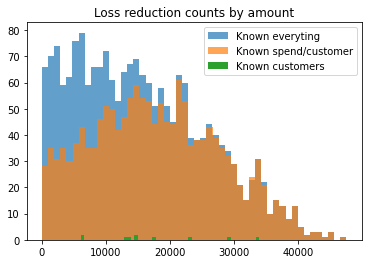

In [164]:
plt.hist(loss_reduction.known_all[loss_reduction.known_all > 0], bins=50,  alpha=0.7, label="Known everyting");
plt.hist(loss_reduction.known_spend_per_customer[loss_reduction.known_spend_per_customer > 0], bins=50, alpha=0.7, label="Known spend/customer");
plt.hist(loss_reduction.known_customers[loss_reduction.known_customers > 0], bins=50, alpha=1, label="Known customers");
plt.title("Loss reduction counts by amount")
plt.legend();

In [121]:
losses.subtract(losses.naive, axis=0).mean()
losses.subtract(losses.naive, axis=0).max()
losses.subtract(losses.naive, axis=0).max()

naive                            0.000000
known_customers              34001.401874
known_spend_per_customer     47616.804796
known_mix                        0.000000
known_spend_and_customers    47616.804796
known_all                    47616.804796
dtype: float64

In [53]:
losses.mean()

naive                       -3117.355386
known_customers             -3111.036513
known_spend_per_customer     -377.196149
known_mix                   -3117.355386
known_spend_and_customers       0.000000
known_all                       0.000000
dtype: float64

In [45]:
t = monotonic()

# Generate N scenarios

actual = {
    'customers_per_day': np.array(customers_per_day.rvs(N)),
    'spend_per_customer': np.array(spend_per_customer.rvs(N)),
    'vat_mix': np.array(vat_mix.rvs(N))
}

reality = model(actual['customers_per_day'], actual['spend_per_customer'], actual['vat_mix'])

# For each scenario, actors produce S simulations

simulations = {
    'customers_per_day': np.broadcast_to(customers_per_day.rvs(S), [N, S]).T,
    'spend_per_customer': np.broadcast_to(spend_per_customer.rvs(S), [N, S]).T,
    'vat_mix': np.broadcast_to(vat_mix.rvs(S), [N, S]).T
}

# Actors combine the information they know with the simulations for the variables they don't know
# And make a deicision based on the average value

def decide(arr):
    return arr.mean(axis=arr.ndim-2) > 0

knows_nothing = decide(model(simulations['customers_per_day'], simulations['spend_per_customer'], simulations['vat_mix']))

knows_customers = decide(model(actual['customers_per_day'], simulations['spend_per_customer'], simulations['vat_mix']))

knows_spend = decide(model(simulations['customers_per_day'], actual['spend_per_customer'], simulations['vat_mix']))

knows_vat = decide(model(simulations['customers_per_day'], simulations['spend_per_customer'], actual['vat_mix']))

knows_customers_and_spend = decide(model(actual['customers_per_day'], actual['spend_per_customer'], simulations['vat_mix']))

knows_everything = decide(np.broadcast_to(reality, (S, N)))

df = pd.DataFrame({
    'knows_nothing': knows_nothing,
    'knows_customers': knows_customers,
    'knows_spend': knows_spend,
    'knows_vat': knows_vat,
    'knows_customers_and_spend': knows_customers_and_spend,
    'knows_everything': knows_everything
}).mul(reality, axis=0)


loss = df.clip(upper=0)

expected_loss = loss.mean()

loss_reduction = (expected_loss - expected_loss.min())

print(loss_reduction)
print(monotonic() - t)


knows_nothing                   0.000000
knows_customers                72.101464
knows_spend                  2772.587926
knows_vat                       0.000000
knows_customers_and_spend    3113.949495
knows_everything             3113.949495
dtype: float64
4.139330345000019
